In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import logging
import random
import pkg_resources
import sklearn
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics.pairwise import pairwise_distances
#from rxnfp.tokenization import *
# from rdkit import Chem
# from rdkit.Chem import rdChemReactions
torch.cuda.is_available()
#import rxnfp
#from rxnfp.models import SmilesClassificationModel
#from rxn_yields.core import SmilesTokenizer, SmilesClassificationModel§1`

logger = logging.getLogger(__name__)
#torch.cuda.is_available()
# from simpletransformers.classification import ClassificationModel, ClassificationArgs
#from rxnfp.tokenization import SmilesTokenizer

/opt/conda/envs/reaction-workbench-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from rxnfp.tokenization import SmilesTokenizer

import os
import pickle

import argparse

from tqdm.auto import tqdm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

### Train Embedding

In [3]:
from transformers import AutoModel

model_path = '../Janssen_project/rxn-data-from-postgresql/models/reaxys_bert/checkpoint-4356432-epoch-36'
pretrained_model = AutoModel.from_pretrained(model_path, output_hidden_states=True)
tokenizer = SmilesTokenizer(vocab_file='../Janssen_project/rxn-data-from-postgresql/models/reaxys_bert/checkpoint-4356432-epoch-36/vocab.txt')

Some weights of BertModel were not initialized from the model checkpoint at ../Janssen_project/rxn-data-from-postgresql/models/reaxys_bert/checkpoint-4356432-epoch-36 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
df_class = pd.read_csv('data/className.tsv', sep='\t', encoding='ISO-8859-1')

In [13]:
# Convert multi Class-ID into one
def clean_class_id(row):
    # Split the string by comma and convert to a list
    class_ids = str(row['CLASS-ID']).split(',')
    # Return the first element from the list, ensuring it's an integer
    return int(class_ids[0].strip())

# Apply the function to the 'CLASS-ID' column
df_class['CLASS-ID'] = df_class.apply(clean_class_id, axis=1)
df_class['CLASS-ID'] = df_class['CLASS-ID'].astype(int)

In [14]:
df_class['SUPER_TRANSFORM_ID'] = df_class['TRANSFORM_ID'].str.extract(r'\((.*?)\)')

In [15]:
df_Name = pd.merge(train, df_class[['CLASS-ID', 'TRANSFORM_NAME', 'TRANSFORM_ID', 'SUPER_TRANSFORM_ID']], on='CLASS-ID', how='left')

In [16]:
df_Name

,CLASS-ID,RX.ID,reaction,product_summary,TRANSFORM_NAME,TRANSFORM_ID,SUPER_TRANSFORM_ID
0,272,20308219,CC1(C)O[C@H]2[C@H]3C[C@@H]([C@H]2O1)C(=O)C3>>C...,CC1(C)O[C@H]2[C@H]3C[C@H](NC(=O)C3)[C@H]2O1,"Beckmann ring expansion, Beckmann ring expansi...","(AEREARR)6.1, (AFCYCLIZ)2.1.2, (ATRNGSIZ)1.4, ...",AEREARR
1,84,20308266,CC(=O)OC(\C=C\c1ccccc1)C#N>>CC(=O)OC(CC(=O)c1c...,CC(=O)OC(CC(=O)c1ccccc1)C#N,oxidation of alkenes to ketones,(ABOXIDAT)2.2.2,ABOXIDAT
2,68,20308388,CC1(C)O[C@H]2[C@H](OC(=O)[C@H]2O1)[C@@H](O)CO>...,C[C@H](O)[C@H]1OC(=O)[C@H]2OC(C)(C)O[C@@H]12,reductive cleavage of alkyl C-O to CH,(AAREDUCT)C.2.1,AAREDUCT
3,1872,20308549,O=Cc1ccccc1>>CC(C)NC(=S)c1ccccc1,CC(C)NC(=S)c1ccccc1,Willgerodt-Kindler rearrangement,(AVNAMEDR)Willgerodt,AVNAMEDR
4,636,20308813,ClC(=O)c1ccccc1>>CCOC(=O)C(F)(F)[C@H](OC(=O)c1...,CCOC(=O)C(F)(F)[C@H](OC(=O)c1ccccc1)[C@H](O)CO,O-benzoylation of alcohols,(AG3ACYO)4.1,AG3ACYO
...,...,...,...,...,...,...,...
2405601,72,20308054,CCc1ccc2c3ccc4c(OC(C)=O)ccc([C@@H]5O[C@H](COC(...,CC(=O)OC[C@H]1O[C@H]([C@H](OC(C)=O)[C@@H]1OC(C...,oxidation of (CH2)2 to C=C,(ABOXIDAT)1.1.1,ABOXIDAT
2405602,42,20308093,CC1(C)C2CC1C(=C)CC2>>C[C@H]1CC[C@H]2C[C@@H]1C2...,C[C@H]1CC[C@H]2C[C@@H]1C2(C)C,reduction of non-conjugated alkenes,(AAREDUCT)4.3,AAREDUCT
2405603,42,20308094,CC1(C)C2CC1C(=C)CC2>>C[C@@H]1CC[C@H]2C[C@@H]1C...,C[C@@H]1CC[C@H]2C[C@@H]1C2(C)C,reduction of non-conjugated alkenes,(AAREDUCT)4.3,AAREDUCT
2405604,256,20308164,COC(=O)CCC[C@H](O)C=CBr>>COC(=O)CCC[C@H](O)C#C,COC(=O)CCC[C@H](O)C#C,=-X -H elimination to alkynes,(ADELIMIN)2.5,ADELIMIN


In [17]:
df_Name = df_Name.drop(columns="product_summary")
df_Name = df_Name.drop(columns="RX.ID")

In [18]:
embeddings = X_train 
df_Name['embedding'] = list(embeddings)

In [19]:
class PairDataset:
    def __init__(self, dataframe):
        self.df = dataframe
        self.pairs = []
        self.targets = []
        self.create_pairs()

    def create_pairs(self):
        positive_pairs = []
        negative_pairs = []
        positive_targets = []
        negative_targets = []

        # Generate positive pairs (label 0 for similar)
        for _, group in tqdm(self.df.groupby('CLASS-ID'), desc='Positive Pairs'):
            indices = group.index.tolist()
            for i in range(len(indices)):
                pair_index = (i + 1) % len(indices)
                positive_pairs.append((indices[i], indices[pair_index]))
                positive_targets.append(0)  # Positive pair (similar)

        # Generate negative pairs (label 1 for dissimilar)
        for _, super_group in tqdm(self.df.groupby('SUPER_TRANSFORM_ID'), desc='Negative Pairs'):
            class_groups = list(super_group.groupby('CLASS-ID'))
            super_transform_id = super_group['SUPER_TRANSFORM_ID'].iloc[0]

            if super_transform_id != 'AVNAMEDR':  # For reactions not in AVNAMEDR
                other_super_groups = [g for g in self.df.groupby('SUPER_TRANSFORM_ID') if g[0] != super_transform_id]
                for class_group in class_groups:
                    indices = class_group[1].index.tolist()
                    if len(other_super_groups) > 0:
                        for i in range(len(indices)):
                            selected_super_group_index = np.random.choice(len(other_super_groups), 1)[0]
                            selected_super_group = other_super_groups[selected_super_group_index]
                            selected_super_group_indices = selected_super_group[1].index.tolist()
                            if len(selected_super_group_indices) > 0:
                                selected_index = np.random.choice(selected_super_group_indices, 1)[0]
                                negative_pairs.append((indices[i], selected_index))
                                negative_targets.append(1)  # Negative pair (dissimilar)
            else:  # For reactions in AVNAMEDR
                if len(class_groups) > 1:
                    for class_group in class_groups:
                        indices = class_group[1].index.tolist()
                        other_class_groups = [g for g in class_groups if g[0] != class_group[0]]
                        for i in range(len(indices)):
                            if len(other_class_groups) > 0:
                                selected_group_index = np.random.choice(len(other_class_groups), 1)[0]
                                selected_group = other_class_groups[selected_group_index]
                                selected_indices = selected_group[1].index.tolist()
                                if len(selected_indices) > 0:
                                    selected_index = np.random.choice(selected_indices, 1)[0]
                                    negative_pairs.append((indices[i], selected_index))
                                    negative_targets.append(1)  # Negative pair (dissimilar)

        # Assign pairs and targets
        self.pairs = positive_pairs + negative_pairs
        self.targets = positive_targets + negative_targets

    def print_sample_pairs_with_distances(self, num_samples):
        from scipy.spatial.distance import euclidean

        print("\nSample Pairs with Distances:")
        sample_indices = np.random.choice(len(self.pairs), num_samples, replace=False)
        for i, idx in enumerate(sample_indices):
            pair = self.pairs[idx]
            target = self.targets[idx]
            embedding1 = self.df.loc[pair[0], 'embedding']
            embedding2 = self.df.loc[pair[1], 'embedding']
            distance = euclidean(embedding1, embedding2)

            pair_type = "Positive" if target == 0 else "Negative"
            print(f"{pair_type} Pair {i + 1}:")
            print(f"Reaction 1 ID: {pair[0]}")
            print(f"Reaction 2 ID: {pair[1]}")
            print(f"Distance: {distance:.4f}")
            print("-" * 30)

    def calculate_average_distances(self):
        positive_distances = []
        negative_distances = []

        for idx, (index1, index2) in enumerate(self.pairs):
            embedding1 = self.df.loc[index1, 'embedding']
            embedding2 = self.df.loc[index2, 'embedding']
            distance = euclidean(embedding1, embedding2)

            if self.targets[idx] == 0:
                positive_distances.append(distance)
            else:
                negative_distances.append(distance)

        avg_positive_distance = np.mean(positive_distances)
        avg_negative_distance = np.mean(negative_distances)

        print(f"Average Positive Pair Distance: {avg_positive_distance:.4f}")
        print(f"Average Negative Pair Distance: {avg_negative_distance:.4f}")

    def plot_distance_distributions(self, num_samples=100):
        positive_distances = []
        negative_distances = []

        sample_indices = np.random.choice(len(self.pairs), num_samples, replace=False)
        for idx in sample_indices:
            pair = self.pairs[idx]
            target = self.targets[idx]
            embedding1 = self.df.loc[pair[0], 'embedding']
            embedding2 = self.df.loc[pair[1], 'embedding']
            distance = euclidean(embedding1, embedding2)

            if target == 0:
                positive_distances.append(distance)
            else:
                negative_distances.append(distance)

        plt.hist(positive_distances, bins=30, alpha=0.5, label='Positive Pairs')
        plt.hist(negative_distances, bins=30, alpha=0.5, label='Negative Pairs')
        plt.xlabel('Distance')
        plt.ylabel('Frequency')
        plt.title('Distance Distribution of Positive and Negative Pairs')
        plt.legend(loc='upper right')
        plt.show()

    def sanity_checks(self):
        print("Performing sanity checks...")
        # Check if positive pairs have the same CLASS-ID
        mismatch_count = 0
        for idx, (index1, index2) in enumerate(self.pairs):
            if self.targets[idx] == 0:  # Positive pair
                if self.df.loc[index1, 'CLASS-ID'] != self.df.loc[index2, 'CLASS-ID']:
                    mismatch_count += 1
                    print(f"Error: Positive pair with different CLASS_IDs found!")
                    print(f"Pair indices: ({index1}, {index2})")
                    print(f"CLASS-ID 1: {self.df.loc[index1, 'CLASS-ID']}, CLASS_ID 2: {self.df.loc[index2, 'CLASS-ID']}")

        assert mismatch_count == 0, "Sanity check failed: Positive pairs with different CLASS_IDs found!"

        # Check if negative pairs have different CLASS-ID
        mismatch_count = 0
        for idx, (index1, index2) in enumerate(self.pairs):
            if self.targets[idx] == 1:  # Negative pair
                if self.df.loc[index1, 'CLASS-ID'] == self.df.loc[index2, 'CLASS-ID']:
                    mismatch_count += 1
                    print(f"Error: Negative pair with the same CLASS_IDs found!")
                    print(f"Pair indices: ({index1}, {index2})")
                    print(f"CLASS-ID 1: {self.df.loc[index1, 'CLASS-ID']}, CLASS-ID 2: {self.df.loc[index2, 'CLASS-ID']}")

        assert mismatch_count == 0, "Sanity check failed: Negative pairs with the same CLASS_IDs found!"

        print(f"Total mismatches in positive pairs: {mismatch_count}")
        print("All sanity checks passed!")


In [20]:
sample_fraction = 0.3  # Use 30% of the data
sample_df = df_Name.sample(frac=sample_fraction, random_state=42)

# Create the dataset and dataloaders
dataset = PairDataset(sample_df)

Negative Pairs: 100%|██████████| 34/34 [20:23<00:00, 35.98s/it]  


In [21]:
dataset.sanity_checks()

Performing sanity checks...
Total mismatches in positive pairs: 0
All sanity checks passed!


In [22]:
print(f"Total number of positive pairs: {sum(1 for t in dataset.targets if t == 1)}")
print(f"Total number of negative pairs: {sum(1 for t in dataset.targets if t == 0)}")

Total number of positive pairs: 721682
Total number of negative pairs: 721682


In [23]:
dataset.calculate_average_distances()

Average Positive Pair Distance: 2.3785
Average Negative Pair Distance: 2.7396


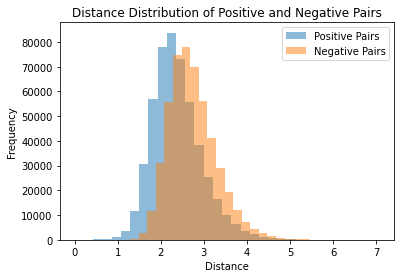

In [24]:
dataset.plot_distance_distributions(1000000)

In [25]:
class ReactionPairDataset(Dataset):
    def __init__(self, dataframe, pairs, targets):
        self.df = dataframe
        self.pairs = pairs
        self.targets = targets

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        index1, index2 = self.pairs[idx]
        reaction1 = self.df.loc[index1, 'reaction']
        reaction2 = self.df.loc[index2, 'reaction']
        label = self.targets[idx]
        return reaction1, reaction2, torch.tensor(label, dtype=torch.float32)

In [26]:
reaction_dataset = ReactionPairDataset(df_Name, dataset.pairs, dataset.targets)
train_size = int(0.9 * len(reaction_dataset))
val_size = len(reaction_dataset) - train_size
train_dataset, val_dataset = random_split(reaction_dataset, [train_size, val_size])

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(987, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


In [29]:
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=1e-6) 
total_steps = len(train_dataloader) * 10  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [30]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=3):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

In [31]:
criterion = ContrastiveLoss(margin=3)

In [32]:
def evaluate_model(dataloader):
    pretrained_model.eval()
    total_loss = 0
    with torch.no_grad():
        for reaction1, reaction2, target in dataloader:
            inputs1 = tokenizer(reaction1, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
            inputs2 = tokenizer(reaction2, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
            target = target.to(device)
            
            embedding1 = pretrained_model(**inputs1).last_hidden_state[:, 0, :]
            embedding2 = pretrained_model(**inputs2).last_hidden_state[:, 0, :]
            
            loss = criterion(embedding1, embedding2, target)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [33]:
num_epochs = 5
accumulation_steps = 4 
#early_stopping_patience = 3
best_val_loss = float('inf')
#patience_counter = 0
scaler = torch.cuda.amp.GradScaler()
for epoch in range(num_epochs):
    pretrained_model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", mininterval=1)  # Update every 100 seconds
    optimizer.zero_grad()

    for i, (reaction1, reaction2, target) in enumerate(progress_bar):
        inputs1 = tokenizer(reaction1, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        inputs2 = tokenizer(reaction2, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        target = target.to(device)

        with torch.cuda.amp.autocast():
            embedding1 = pretrained_model(**inputs1).last_hidden_state[:, 0, :]
            embedding2 = pretrained_model(**inputs2).last_hidden_state[:, 0, :]
            loss = criterion(embedding1, embedding2, target)
            loss = loss / accumulation_steps  # Scale the loss

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(pretrained_model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

        # Print loss less frequently
        if (i + 1) % (len(train_dataloader) // 10) == 0:
            progress_bar.set_postfix(loss=total_loss / ((i + 1) // accumulation_steps if (i + 1) // accumulation_steps > 0 else 1))

    val_loss = evaluate_model(val_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss / len(train_dataloader)}, Validation Loss: {val_loss}")

    scheduler.step()

Epoch 3/5:  93%|█████████▎| 37601/40595 [1:08:40<05:38,  8.84it/s, loss=2.92]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 3/5: 100%|██████████| 40595/40595 [1:14:11<00:00,  9.12it/s, loss=2.9] 


Epoch 3/5, Training Loss: 0.7257608642732588, Validation Loss: 0.3973694630008504


Epoch 5/5:  74%|███████▎  | 29875/40595 [54:37<19:46,  9.04it/s, loss=2.4]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 5/5: 100%|██████████| 40595/40595 [1:14:19<00:00,  9.10it/s, loss=2.37]


Epoch 5/5, Training Loss: 0.593158836418118, Validation Loss: 0.32688233528861815


In [34]:
pretrained_model.save_pretrained('data/fine_tuned_model_Final0.3')
tokenizer.save_pretrained('data/fine_tuned_model_Final0.3')

('data/fine_tuned_model_Final0.3/tokenizer_config.json',
 'data/fine_tuned_model_Final0.3/special_tokens_map.json',
 'data/fine_tuned_model_Final0.3/vocab.txt',
 'data/fine_tuned_model_Final0.3/added_tokens.json')

### Data Load

In [4]:
X_train1 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train1_PreBertFP.npy',allow_pickle=True)
X_train2 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train2_PreBertFP.npy',allow_pickle=True)
X_train3 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train3_PreBertFP.npy',allow_pickle=True)
X_train4 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train4_PreBertFP.npy',allow_pickle=True)
X_train5 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train5_PreBertFP.npy',allow_pickle=True)
X_train6 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train6_PreBertFP.npy',allow_pickle=True)
X_train7 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train7_PreBertFP.npy',allow_pickle=True)
X_train8 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train8_PreBertFP.npy',allow_pickle=True)
X_train9 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train9_PreBertFP.npy',allow_pickle=True)
X_train10 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train10_PreBertFP.npy',allow_pickle=True)

In [5]:
X_train = np.concatenate([X_train1, X_train2, X_train3, X_train4, X_train5,
                          X_train6, X_train7, X_train8, X_train9, X_train10], axis=0)

In [6]:
X_train1 = np.vstack(X_train)
X_train = np.squeeze(X_train1)

In [7]:
#X_train = np.load('data/RXNFP/X_train_RXNFP.npy')
X_test = np.load('../ReactionClassification_2024/data/PreBertFP/X_test_PreBertFP.npy',allow_pickle=True)
X_val = np.load('../ReactionClassification_2024/data/PreBertFP/X_val_PreBertFP.npy',allow_pickle=True)

In [8]:
X_test1 = np.vstack(X_test)
X_test = np.squeeze(X_test1)

In [9]:
X_val1 = np.vstack(X_val)
X_val = np.squeeze(X_val1)

In [10]:
train = pd.read_csv('../ReactionClassification_2024/data/train.csv', delimiter=',')
test = pd.read_csv('../ReactionClassification_2024/data/test.csv', delimiter=',')
val = pd.read_csv('../ReactionClassification_2024/data/val.csv', delimiter=',')

In [11]:
y_train = train['CLASS-ID'].values
y_test = test['CLASS-ID'].values
y_val = val['CLASS-ID'].values